# [Anything From Scratch] Lenet with Torh in MNIST

- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

## LeNet-5 MNIST Digits Classifier

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to MNIST digit classification. The basic architecture is shown in the figure below:

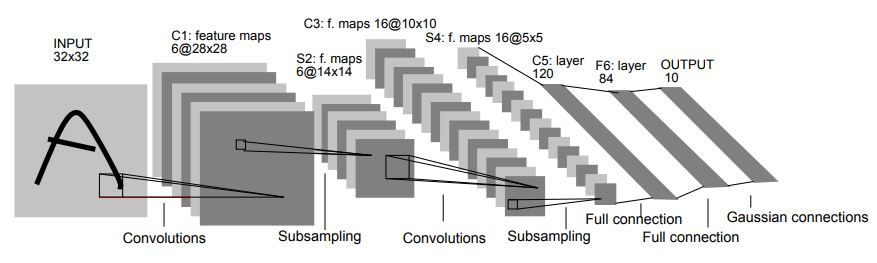

LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (In this notebook, we replace these with ReLU activations)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (In this notebook, we replace these with softmax activations)
- The input size is 32x32; here, we rescale the MNIST images from 28x28 to 32x32 to match this input dimension. Alternatively, we would have to change the

achieve error rate below 1% on the MNIST data set, which was very close to the state of the art at the time (produced by a boosted ensemble of three LeNet-4 networks).

### Import

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

#### Model Setting and Setting up Config

In [10]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = 'cuda'
GRAYSCALE = True

#### MNIST Dataset

In [3]:
##########################
### MNIST DATASET
##########################

# Resize Input image to 32x32 pixels and change the image ti a torch tensor
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Scale input image to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=resize_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=resize_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 343606598.82it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40432474.57it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 224308880.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9403025.06it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [4]:
##########################
### MODEL
##########################

class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            # Conv filter with output ís 6 with filter 5x5
            # Note after nn.Conv2D, input -> 6@28x28 with 6 is the number of kenel
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [5]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to('cuda')
# Sometime ou can set up to 'cuda' (gpu)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
print(DEVICE)

cuda:1


### Training

In [7]:
# Calculate the accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        # Finding the pair (value, index) that value ís max in probas
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [11]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.2981
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.5492
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.2983
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.3314
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1444
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1568
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.1104
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.2003
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1309
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.1193
Epoch: 001/010 | Train: 97.413%
Time elapsed: 0.53 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0473
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.1127
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0974
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.1073
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0428
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.1265
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.1474
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0483
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0825
Epoch: 002/010 | Batch 0450/0469 

#### Evaluation

In [12]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))


Test accuracy: 98.75%


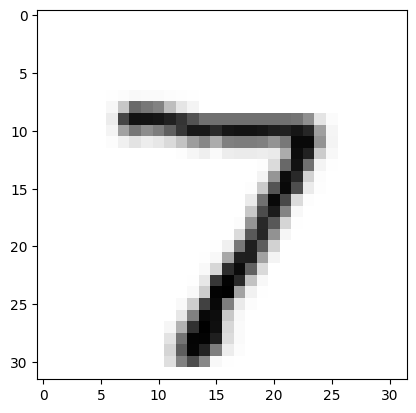

In [15]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break


nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [17]:
model.eval()
logits, probas = model(features.to(DEVICE)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%
